<a href="https://colab.research.google.com/github/rahiakela/hands-on-machine-learning-with-scikit-learn-keras-and-tensorflow/blob/17-representation-learning-and-generative-learning-using-autoencoders-and-gans/1_pca_linear_autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Performing PCA with an Undercomplete Linear Autoencoder

Autoencoders are artificial neural networks capable of learning dense representations of the input data, called latent representations or codings, without any supervision (i.e., the training set is unlabeled). These codings typically have a much lower dimensionality than the input data, making autoencoders useful for dimensionality reduction, especially for visualization purposes. 

Autoencoders also act as feature detectors, and they can be used for unsupervised pretraining of deep neural networks. Lastly, some autoencoders are generative models: they are capable of randomly generating new data that looks very similar to the training data.

For example, you could train an autoencoder on pictures of faces, and it would then be able to generate new faces. However, the generated images are usually fuzzy and not entirely realistic.

In contrast, faces generated by generative adversarial networks (GANs) are now so convincing that it is hard to believe that the people they represent do not exist. You can judge so for yourself by visiting https://thispersondoesnotexist.com/, a website that shows faces generated by a recent GAN architecture called StyleGAN (you can also check out https://thisrentaldoesnotexist.com/ to see some generated Airbnb bedrooms).

GANs are now widely used for super resolution (increasing the resolution of
an image), colorization, powerful image editing (e.g., replacing photo bombers with realistic background), turning a simple sketch into a photorealistic image, predicting the next frames in a video, augmenting a dataset (to train other models), generating other types of data (such as text, audio, and time series), identifying the weaknesses in other models and strengthening them, and more.

Autoencoders and GANs are both unsupervised, they both learn dense representations, they can both be used as generative models, and they have many similar applications.

However, they work very differently:

* Autoencoders simply learn to copy their inputs to their outputs. This may sound like a trivial task, but we will see that constraining the network in various ways can make it rather difficult. For example, you can limit the size of the latent representations, or you can add noise to the inputs and train the network to recover the original inputs. These constraints prevent the autoencoder from trivially copying the inputs directly to the outputs, which forces it to learn efficient ways of representing the data. In short, the codings are byproducts of the autoencoder learning the identity function under some constraints.

* GANs are composed of two neural networks: a generator that tries to generate data that looks similar to the training data, and a discriminator that tries to tell real data from fake data. This architecture is very original in Deep Learning in that the generator and the discriminator compete against each other during training: the generator is often compared to a criminal trying to make realistic counterfeit money, while the discriminator is like the police investigator trying to tell real money from fake.

We will start by exploring in more depth how autoencoders work and how to use them for dimensionality reduction, feature extraction, unsupervised pretraining, or as generative models. This will naturally lead us to GANs. We will start by building a simple GAN to generate fake images, but we will see that training is often quite difficult.



## Setup

In [0]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
    IS_COLAB = True
except Exception:
    IS_COLAB = False

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. LSTMs and CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

A couple utility functions to plot grayscale 28x28 image:

In [0]:
def plot_image(image):
    plt.imshow(image, cmap="binary")
    plt.axis("off")

## Efficient Data Representations

Which of the following number sequences do you find the easiest to memorize?

* 40, 27, 25, 36, 81, 57, 10, 73, 19, 68
* 50, 48, 46, 44, 42, 40, 38, 36, 34, 32, 30, 28, 26, 24, 22, 20, 18, 16, 14

At first glance, it would seem that the first sequence should be easier, since it is much shorter. However, if you look carefully at the second sequence, you will notice that it is just the list of even numbers from 50 down to 14. Once you notice this pattern, the second sequence becomes much easier to memorize than the first because you only need to remember the pattern (i.e., decreasing even numbers) and the starting and ending numbers (i.e., 50 and 14). 

Note that if you could quickly and easily memorize very long sequences, you would not care much about the existence of a pattern in the second sequence. You would just learn every number by heart, and that would be
that. 

The fact that it is hard to memorize long sequences is what makes it useful to recognize patterns, and hopefully this clarifies why constraining an autoencoder during training pushes it to discover and exploit patterns in the data.

An autoencoder looks at the inputs, converts them to an efficient latent representation, and then spits out something that (hopefully) looks very close to the inputs. An autoencoder is always composed of two parts: an encoder (or recognition network) that converts the inputs to a latent representation, followed by a decoder (or generative network) that converts the internal representation to the outputs.

<img src='https://github.com/rahiakela/img-repo/blob/master/hands-on-machine-learning-keras-tensorflow/simple-autoencoder.png?raw=1' width='800'/>

As you can see, an autoencoder typically has the same architecture as a Multi-Layer Perceptron, except that the number of neurons in the output
layer must be equal to the number of inputs. In this example, there is just one hidden layer composed of two neurons (the encoder), and one output layer composed of three neurons (the decoder). 

The outputs are often called the reconstructions because the autoencoder tries to reconstruct the inputs, and the cost function contains a reconstruction loss that penalizes the model when the reconstructions are different from the inputs.

Because the internal representation has a lower dimensionality than the input data (it is 2D instead of 3D), the autoencoder is said to be undercomplete. An undercomplete autoencoder cannot trivially copy its inputs to the codings, yet it must find a way to output a copy of its inputs. It is forced to learn the most important features in the input data (and drop the unimportant ones).


Let’s see how to implement a very simple undercomplete autoencoder for dimensionality reduction.

## PCA with an Undercomplete Linear Autoencoder

If the autoencoder uses only linear activations and the cost function is the mean squared error (MSE), then it ends up performing Principal Component Analysis.

Let's generate 3D dataset:

In [5]:
np.random.seed(4)

def generate_3d_data(m, w1=0.1, w2=0.3, noise=0.1):
  angles = np.random.rand(m) * 3 * np.pi / 2 - 0.5
  data = np.empty((m, 3))
  data[:, 0] = np.cos(angles) + np.sin(angles)/2 + noise * np.random.randn(m) / 2
  data[:, 1] = np.sin(angles) * 0.7 + noise * np.random.randn(m) / 2
  data[:, 2] = data[:, 0] * w1 + data[:, 1] * w2 + noise * np.random.randn(m)
  return data

X_train = generate_3d_data(60)
X_train = X_train - X_train.mean(axis=0, keepdims=0)
print(X_train.shape)

(60, 3)


Now let's build the Autoencoder...

In [0]:
np.random.seed(42)
tf.random.set_seed(42)

encoder = keras.models.Sequential([keras.layers.Dense(2, input_shape=[3])])
decoder = keras.models.Sequential([keras.layers.Dense(3, input_shape=[2])])

autoencoder = keras.models.Sequential([encoder, decoder])
autoencoder.compile(loss='mse', optimizer=keras.optimizers.SGD(learning_rate=1.5))

* We organized the autoencoder into two subcomponents: the encoder and the
decoder. Both are regular Sequential models with a single Dense layer each, and the autoencoder is a Sequential model containing the encoder followed by the decoder (remember that a model can be used as a layer in another model).

* The autoencoder’s number of outputs is equal to the number of inputs (i.e., 3).

* To perform simple PCA, we do not use any activation function (i.e., all neurons are linear), and the cost function is the MSE.

Now let’s train the model on a simple generated 3D dataset and use it to encode that same dataset (i.e., project it to 2D):

In [7]:
history = autoencoder.fit(X_train, X_train, epochs=20)

Train on 60 samples
Epoch 1/20
60/60 [==============================] - 2s 32ms/sample - loss: 0.3064
Epoch 2/20
60/60 [==============================] - 0s 134us/sample - loss: 0.3797
Epoch 3/20
60/60 [==============================] - 0s 112us/sample - loss: 0.1454
Epoch 4/20
60/60 [==============================] - 0s 147us/sample - loss: 0.0872
Epoch 5/20
60/60 [==============================] - 0s 162us/sample - loss: 0.0658
Epoch 6/20
60/60 [==============================] - 0s 144us/sample - loss: 0.0464
Epoch 7/20
60/60 [==============================] - 0s 167us/sample - loss: 0.0356
Epoch 8/20
60/60 [==============================] - 0s 153us/sample - loss: 0.0238
Epoch 9/20
60/60 [==============================] - 0s 150us/sample - loss: 0.0225
Epoch 10/20
60/60 [==============================] - 0s 137us/sample - loss: 0.0093
Epoch 11/20
60/60 [==============================] - 0s 132us/sample - loss: 0.0068
Epoch 12/20
60/60 [==============================] - 0s 144us/samp

In [0]:
codings = encoder.predict(X_train)

In [9]:
codings[:10]

array([[-1.5274061 ,  0.00450174],
       [ 0.29497597,  0.30931056],
       [-1.4017817 ,  0.03030768],
       [-0.96917593,  0.6367279 ],
       [-0.8871722 ,  0.59361136],
       [ 1.2372295 , -0.4703033 ],
       [-1.6398767 ,  0.01756443],
       [ 0.42794442, -0.78036684],
       [ 1.215723  , -0.1822743 ],
       [ 0.8950341 ,  0.10711112]], dtype=float32)

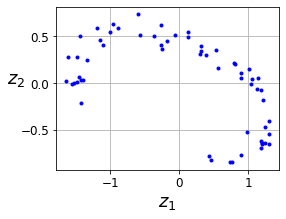

In [10]:
fig = plt.figure(figsize=(4,3))
plt.plot(codings[:,0], codings[:, 1], "b.")
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18, rotation=0)
plt.grid(True)

plt.show()

Note that the same dataset, X_train, is used as both the inputs and the targets.This shows the original 3D dataset (on the left) and the output of the autoencoder’s hidden layer (i.e., the coding layer, on the right). As you can see, the autoencoder found the best 2D plane to project the data onto, preserving as much variance in the data as it could (just like PCA).

<img src='https://github.com/rahiakela/img-repo/blob/master/hands-on-machine-learning-keras-tensorflow/linear-autoencoder.png?raw=1' width='800'/>

You can think of autoencoders as a form of self-supervised learning
(i.e., using a supervised learning technique with automatically generated
labels, in this case simply equal to the inputs).